In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
from datetime import datetime
from tqdm import tqdm
import os
import ast
import pickle

# Importing the data

In [2]:
DATA_FOLDER = 'data/'

In [3]:
# reading a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [4]:
# importing the data
plots = pd.read_csv(DATA_FOLDER + 'plot_summaries.txt',header=None, sep="\t")
movies = pd.read_csv(DATA_FOLDER + 'movies_metadata.tsv',header=None, sep="\t")
characters = pd.read_csv(DATA_FOLDER + 'characters_metadata.tsv',header=None, sep="\t")
names = pd.read_csv(DATA_FOLDER + 'names_clusters.txt',header=None, sep="\t")
tvtropes = pd.read_csv(DATA_FOLDER + 'tvtropes_clusters.txt',header=None, sep="\t")

In [5]:
# renaming columns the plots dataframe
plots.columns = ['wikipedia_movie_id', 'plot']

`movies` data

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [6]:
# renaming the movie dataframe columns
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']

`characters` data:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [7]:
# fixing the character columns
characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'date_of_birth', 'gender', 'height', 'ethnicity', 'name', 'age_at_release', 'freebase_character_map_id', 'freebase_caracter_id', 'freebase_actor_id']

# Data preprocessing

In [8]:
revenue_nans = movies[movies['revenue'].isna()]["wikipedia_movie_id"]
print('Number of movies without revenue data: ', revenue_nans.shape[0])

Number of movies without revenue data:  73340


### Scraping

A lot of the movies have empty Box Office Revenue so one idea ot fix this is to acquire that data through other means.

Here we scraped the ImDB website to retrieve some of these informations about movie revenues as well as additional interesting informations such as movie ratings, movie producers...

In [9]:
# reading the scraped dataset
imdb_movies = pd.read_csv(DATA_FOLDER + 'imdb_scraped_dataset.csv')
imdb_movies.head(3)

,wikipedia_movie_id,name,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,release_year
0,975900,Ghosts of Mars,14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000.0
2,28463795,Brun bitter,NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988.0


In [10]:
# computing number of movies without global revenue data in the imdb dataset
global_revenue_nans = imdb_movies[imdb_movies['global_revenue'].isna()]["wikipedia_movie_id"]
print('Number of movies without global revenue data: ', global_revenue_nans.shape[0])

Number of movies without global revenue data:  64912


We have less missing revenue data in the scraped data

In [11]:
# calculating number of movies that have missing revenue in the original dataset but don't have missing revenue in the imdb dataset
(~global_revenue_nans.isin(revenue_nans)).value_counts()

wikipedia_movie_id
False    63468
True      1444
Name: count, dtype: int64

1444 scraped movies have revenue informations not present in out original dataset. We can thus complete our revenue data with them.

### Completting missing date data

In [12]:
imdb_movies.drop(columns=['name'], inplace=True)
imdb_movies["imdb_release_date"] = pd.to_datetime(imdb_movies["release_year"], format="%Y")
movies_augmented = pd.merge(movies, imdb_movies, on="wikipedia_movie_id")
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,release_year,imdb_release_date
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0,2001-01-01
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000.0,2000-01-01
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988.0,1988-01-01


Similarly to the previous part, we see that the scraping was able to retrieve 1711 release years that were missing in our original data. We can similarly complete them.

In [13]:
missing_dates = movies_augmented[movies_augmented['release_date'].isna()].index.values

In [14]:
# filling the missing dates with the imdb dates
movies_augmented.loc[missing_dates, "release_date"] = movies_augmented.loc[missing_dates, "imdb_release_date"]

# replace NaT with nans
movies_augmented["release_date"].where(movies_augmented["release_date"].notnull(), None, inplace=True)
movies_augmented.drop(columns=['release_year', 'imdb_release_date'], inplace=True)
movies_augmented.loc[missing_dates, "release_date"].head(3)

15    1941-01-01 00:00:00
74    1927-01-01 00:00:00
81    1977-01-01 00:00:00
Name: release_date, dtype: object

We can also create a year feature in our dataset

In [15]:
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen


In [16]:
"""extracting the year from the release date feature"""

# extracting the years from the release date feature
movie_with_date = movies_augmented[-movies_augmented["release_date"].isna()].copy(deep=True)
dates = movie_with_date["release_date"]
date_years = dates.astype(str).str.extract(r'(\d{4})')

# adding an index column & renaiming the date_years columns
date_years["index"] = date_years.index
date_years.columns = ["year", "index"]

# adding an index column to the movies_augmented dataframe
movies_augmented["index"] = movies_augmented.index

# merging the movies_augmented and date_years dataframes on the index column
merged = pd.merge(movies_augmented, date_years, on="index", how="left")
merged.drop(columns=["index"], inplace=True)
movies_augmented = merged.copy(deep=True)
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,global_revenue,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",14010832.0,28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",NaN,NaN,NaN,NaN,6.0,69.0,NaN,Edward Lucas,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,NaN,NaN,NaN,5.6,40.0,NaN,Sølve Skagen,1988


In [17]:
# filling the missing dates with the imdb dates
missing_revenue = movies_augmented[movies_augmented['revenue'].isna()].index.values
movies_augmented.loc[missing_revenue, "revenue"] = movies_augmented.loc[missing_revenue, "global_revenue"]
movies_augmented.loc[missing_revenue, "revenue"].head(3)

1   NaN
2   NaN
3   NaN
Name: revenue, dtype: float64

### Removing useless data
We shouldn't consider movies with no revenue data, no valid date or no valid ratingwe shouldn't consider movies with no revenue data, no valid date or no valid rating

In [18]:
#droping missing revenue, date & rating datapoints
revenue_nans_filter         = movies_augmented['revenue'].isna()
release_date_nans_filter    = movies_augmented['release_date'].isna()
rating_nans_filter          = movies_augmented['rating_score'].isna()

movies_augmented = movies_augmented[~(revenue_nans_filter | release_date_nans_filter | rating_nans_filter)].copy(deep=True)

# dropping the global_revenue column
movies_augmented.drop(columns=["global_revenue"], inplace=True)

# checking we removed all the useless datapoints
missing_revenue = movies_augmented["revenue"].isna().sum()
missing_dates = movies_augmented["release_date"].isna().sum()
missing_rating = movies_augmented["rating_score"].isna().sum()

print(f"Missing release date datapoints: {missing_revenue}")
print(f"Missing rating datapoints: {missing_dates}")
print(f"Missing revenue datapoints: {missing_rating}")

Missing release date datapoints: 0
Missing rating datapoints: 0
Missing revenue datapoints: 0


In [19]:
movies_augmented.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001
7,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,NaN,NaN,6.8,2300.0,NaN,Henry King,1938
13,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,10161099.0,64933.0,7.5,31000.0,NaN,Kenneth Branagh,1989


In [20]:
movies_augmented.shape

(17766, 17)

We are left with close to 18000 clean datapoints, which is a lot less than the total numbers of movies we had at the beginning. But this is necessary to correctly define the next analysis steps we will conduct.

In [21]:
# converting years to floats & defining a new dataframe
movies = movies_augmented.copy(deep=True)
movies["year"] = movies["year"].astype(float)

## Taking care of inflation

Comparing movie revenues across different periods of time is not relevant as the value of the USD has varied inbetween. This calls for taking inflation into account and adjusting revenues across all time periods on a single reference date.

In [22]:
# inflation data from:
# https://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/
us_inflation = pd.read_csv("US_yearly_inflation.csv")
us_yearly_inflation = us_inflation[["Year", "Avg-Avg"]].fillna(0)
us_yearly_inflation.rename(columns={"Year": "year", "Avg-Avg": "avg_avg"}, inplace=True)
us_yearly_inflation.head(3)

,year,avg_avg
0,1913,0.0
1,1914,1.0
2,1915,1.0


In [23]:
# the 1897 datapoint needs to be removed as we have no inflation data for before 1913
movies = movies[movies["year"] >= 1913]

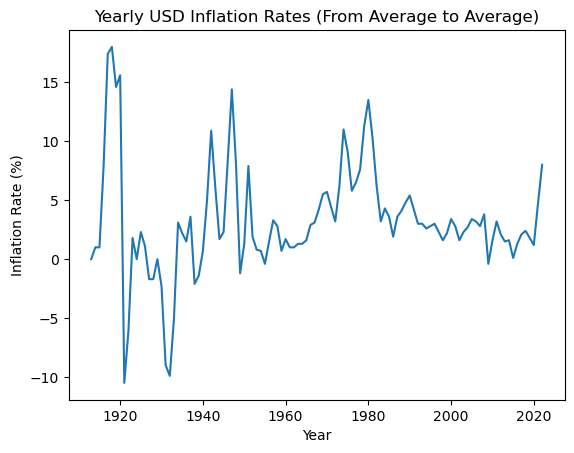

In [24]:
# plotting the yearly USD Inflation Rates
plt.plot(us_yearly_inflation['year'], us_yearly_inflation['avg_avg'])
plt.title("Yearly USD Inflation Rates (From Average to Average)")
plt.xlabel("Year")
plt.ylabel("Inflation Rate (%)")
plt.grid(False)
plt.show()

In [25]:
prices = [1] # we set the initial price as a reference

# Calculate prices based on inflation rates
for index, row in us_yearly_inflation.iterrows():
    if index == 0:
        continue # Skip the first row (no inflation data for the initial price)
    price = prices[-1] * (1 + row['avg_avg'] / 100)
    prices.append(price)

# Add the prices to the DataFrame
us_yearly_inflation['price'] = prices

In [26]:
reference_price = us_yearly_inflation[us_yearly_inflation["year"]==2012]["price"].values[0]
correction_factor = reference_price / us_yearly_inflation["price"]
us_yearly_inflation["correlation_factor"] = correction_factor
us_yearly_inflation.drop(columns=['price', 'avg_avg'], inplace=True)

merged_all = pd.merge(movies, us_yearly_inflation, on="year", how="left")
movies = merged_all.copy(deep=True)

# inflation adjusted revenue
movies["adjusted_revenue"] = movies["revenue"] * movies["correlation_factor"]
movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0,1.295952,1.815737e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,NaN,NaN,6.8,2300.0,NaN,Henry King,1938.0,16.274561,5.858842e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,10161099.0,64933.0,7.5,31000.0,NaN,Kenneth Branagh,1989.0,1.852181,1.882019e+07


### Box office revenue

We need to adjust movie revenues to inflation to make them comparable. As we have inflation data up to 2012, we will place our reference USD value at year 2012.

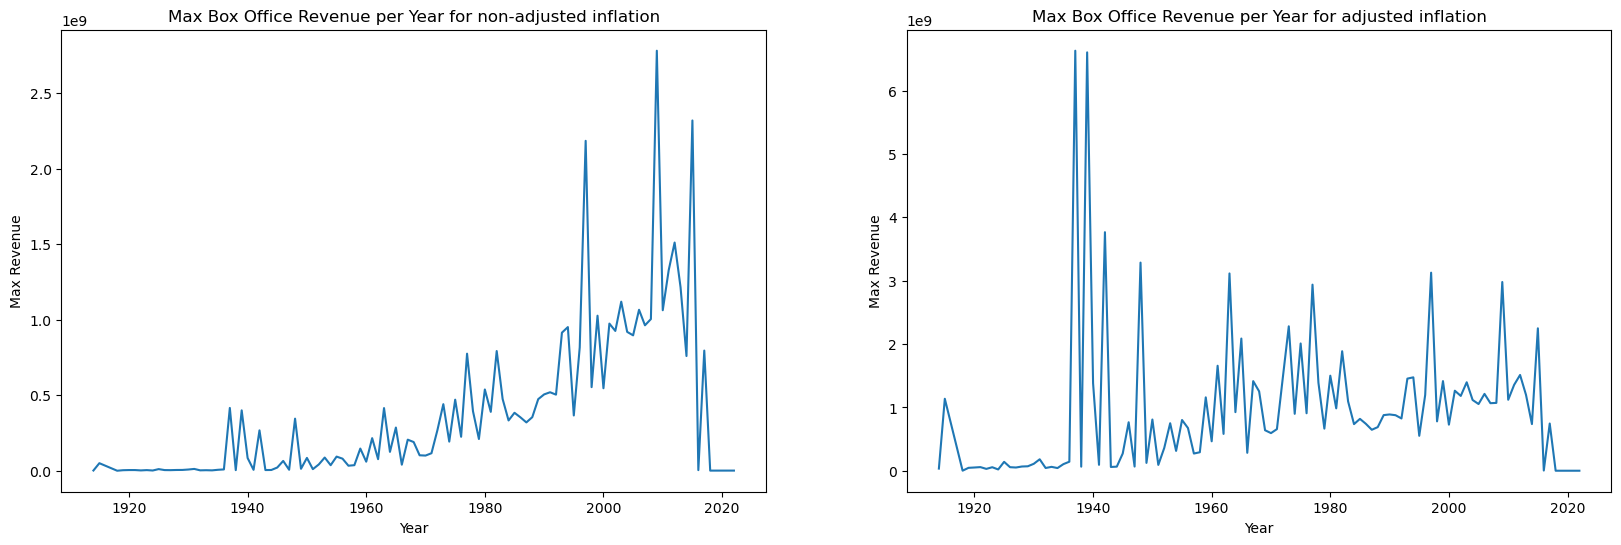

In [27]:
# Calculate the max box office revenue for each year
max_revenue_per_year = movies.groupby('year')['revenue'].max().reset_index()
max_revenue_per_year_adjusted = movies.groupby('year')['adjusted_revenue'].max().reset_index()


fig, axes = plt.subplots(1, 2, figsize=(20, 6))
# Create a line plot
axes[0].plot(max_revenue_per_year['year'], max_revenue_per_year['revenue'])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Max Revenue')
axes[0].set_title('Max Box Office Revenue per Year for non-adjusted inflation')
plt.grid(False)

# Create a line plot
axes[1].plot(max_revenue_per_year_adjusted['year'], max_revenue_per_year_adjusted['adjusted_revenue'])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Max Revenue')
axes[1].set_title('Max Box Office Revenue per Year for adjusted inflation')
plt.grid(False)
plt.grid(False)

plt.show()

We can plot the max box office revenue for every year. Note that we are interested in the best movies so we don't plot average or median.

In [28]:
# movie with most revenue
highest_revenue_movie = movies[movies["revenue"]==movies["revenue"].max()]["name"].values[0]

# movie with most revenue
highest_adjusted_revenue_movie = movies[movies["adjusted_revenue"]==movies["adjusted_revenue"].max()]["name"].values[0]

print(f"Highest revenue movie: {highest_revenue_movie}")
print(f"Highest adjusted revenue movie: {highest_adjusted_revenue_movie}")

Highest revenue movie: Avatar
Highest adjusted revenue movie: Snow White and the Seven Dwarfs


Looking at the previous graph it seems like Avatar is the best movie! Until we adjust the revenue for inflation and see that it is actually Snow White and the Seven Dwarfs that is the movie that generated the most value.

In [29]:
movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,gross_domestic,opening_weekend,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,8709640.0,3804452.0,4.9,57000.0,3850.0,John Carpenter,2001.0,1.295952,1.815737e+07
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,NaN,NaN,6.8,2300.0,NaN,Henry King,1938.0,16.274561,5.858842e+07
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,10161099.0,64933.0,7.5,31000.0,NaN,Kenneth Branagh,1989.0,1.852181,1.882019e+07


## Looking for a correlation between the rating and the revenue

In [30]:
pearson_corr = stats.pearsonr(movies['rating_score'], movies['adjusted_revenue'])

print('Pearson correlation coefficient: ', pearson_corr)
print('As we can see there is a weak correlation between the rating and the revenue')

Pearson correlation coefficient:  PearsonRResult(statistic=0.13717802143813307, pvalue=2.329908373947409e-75)
As we can see there is a weak correlation between the rating and the revenue


The null-hypothesis states that there is no correlation between movie revenue and ratings. Based on this Pearson Correlation test, the p-value is smaller than 0.05, so we reject the null-hypothesis. However, the correlation coefficient is equal to 0.14, which is quite small. So we conclude that there is not a significant correlation between movie revenue and ratings.

### Therefore, we can define a success movie score, which combines both the revenue and ratings.

We define the score as a function composed of two components:

- $BORC$    : Box Office Revenue Component
- $RC$      : Rating Component

These components can be computed with the Adjusted Movie Revenue (which we write define as $AMR$) and the movie rating (we will write as $MR$)

We log-transform the data and define $x = \log(AMR)$ and $y = MR$

$
\begin{cases}
    BORC = \frac{x - \min(x)}{\max(x) - \min(x)}\\
    RC = \frac{y - \min(y)}{\max(y) - \min(y)}
\end{cases}
$

As such, we have $BORC, RC \in [0, 1]$

We define a weight $\alpha \in [0, 1]$ and take the convex combinations of $BORC$ and $RC$. This weight controls the importance we give to each of our two components in our metric. Its importance will be determined in the future and we will adjust it accordingly to the study. Multiplying by 100 gives us a final score 

$$Movie Score = 100\left(\alpha BORC + (1 - \alpha) RC \right)$$

In [31]:
# Calculate the components
log_adj_revenue = np.log(movies['adjusted_revenue'].values)
movie_rating = movies['rating_score'].values

movies.loc[:, 'BORC'] = (log_adj_revenue - np.min(log_adj_revenue)) / (np.max(log_adj_revenue) - np.min(log_adj_revenue))
movies.loc[:, 'RC'] = (movie_rating - np.min(movie_rating)) / (np.max(movie_rating) - np.min(movie_rating))

# Calculate Movie Score
alpha = 1/2
movies.loc[:, 'movie_score'] = 100 * (alpha*movies['BORC'] + (1 - alpha)*movies['RC'])

movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue,BORC,RC,movie_score
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",28000000.0,...,4.9,57000.0,3850.0,John Carpenter,2001.0,1.295952,1.815737e+07,0.726723,0.463415,59.506901
1,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",2000000.0,...,6.8,2300.0,NaN,Henry King,1938.0,16.274561,5.858842e+07,0.780983,0.695122,73.805262
2,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",9000000.0,...,7.5,31000.0,NaN,Kenneth Branagh,1989.0,1.852181,1.882019e+07,0.728384,0.780488,75.443593


### Now that we have the movie scores we can keep the top T percent and consider these as the Good films that we want to study

In [32]:
T = 75
num_movies  = movies.shape[0]
movies      = movies.sort_values("movie_score", ascending = False)

df_good_movies  = movies[movies["movie_score"] >= T].copy()
df_bad_movies   = movies[movies["movie_score"] < T].copy()

In [33]:
df_good_movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue,BORC,RC,movie_score
8110,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",6000000.0,...,9.2,2000000.0,65.0,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194
17595,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",94000000.0,...,9.0,1900000.0,248.0,Peter Jackson,2003.0,1.246866,1.396402e+09,0.927864,0.963415,94.563911
8476,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",185000000.0,...,9.0,2800000.0,120.0,Christopher Nolan,2008.0,1.066249,1.071109e+09,0.915580,0.963415,93.949723


In [34]:
df_bad_movies.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,budget,...,rating_score,number_of_ratings,watched_rank,producer,year,correlation_factor,adjusted_revenue,BORC,RC,movie_score
2118,28272795,/m/0g4pmz_,One Day,2011-08-08,56706628.0,107.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/068d7h"": ""Romantic drama"", ""/m/02l7c8"": ""...",15000000.0,...,7.0,161000.0,3126.0,Lone Scherfig,2011.0,1.021000,5.789747e+07,0.780434,0.719512,74.997299
1590,5301628,/m/0ddf9m,Eye of the Needle,1981-07-24,17583634.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",NaN,...,7.1,12000.0,NaN,Richard Marquand,1981.0,2.526257,4.442078e+07,0.768161,0.731707,74.993418
10259,1528272,/m/0586x1,Murder in the First,1995-01-20,17381942.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,...,7.3,30000.0,NaN,Marc Rocco,1995.0,1.507163,2.619741e+07,0.743703,0.756098,74.990022


We now have 2 datasets: of good movies and of bad ones

# Features
## We will find the effect of each feature on the movie’s success score. 

In [35]:
processed_directory = "processed_data"
try:
    os.makedirs(processed_directory)
except:
    pass

In [36]:
merged = movies.copy(deep=True)

In [37]:
merged["countries"].iloc[5]

'{"/m/09c7w0": "United States of America"}'

In [38]:
for key in ast.literal_eval(merged["countries"][5]).keys():
    print(key)

/m/09c7w0


In [39]:
# country dataframe & dictionary
try:
    movie_countries     = pd.read_csv(processed_directory + "/movie_countries.csv")
    country_dictionary  = pickle.load(open(processed_directory + "/country_dictionary.pickle", "rb"))

except:
    movie_countries = pd.DataFrame(columns=["wikipedia_movie_id", "country_id"])
    country_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["countries"][i])
        data = [{'wikipedia_movie_id': wikiID, 'country_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_countries = pd.concat([movie_countries, dataframe], axis=0)
        country_dictionary.update(dico)

    # save the dataframe to csv
    movie_countries.to_csv(processed_directory + "/movie_countries.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/country_dictionary.pickle', 'wb') as handle:
        pickle.dump(country_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# language dataframe & dictionary
try:
    movie_languages     = pd.read_csv(processed_directory + "/movie_languages.csv")
    language_dictionary = pickle.load(open(processed_directory + "/language_dictionary.pickle", "rb"))
except:
    movie_languages = pd.DataFrame(columns=["wikipedia_movie_id", "language_id"])
    language_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["languages"][i])
        data = [{'wikipedia_movie_id': wikiID, 'language_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_languages = pd.concat([movie_languages, dataframe], axis=0)
        language_dictionary.update(dico)

    # save the dataframe to csv
    movie_languages.to_csv(processed_directory + "/movie_languages.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/language_dictionary.pickle', 'wb') as handle:
        pickle.dump(language_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
try:
    movie_genres        = pd.read_csv(processed_directory + "/movie_genres.csv")
    genre_dictionary   = pickle.load(open(processed_directory + "/genre_dictionary.pickle", "rb"))
except:
    movie_genres = pd.DataFrame(columns=["wikipedia_movie_id", "genre_id"])
    genre_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wiki_id = movies["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["genres"][i])
        data = [{'wikipedia_movie_id': wiki_id, 'genre_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_genres = pd.concat([movie_genres, dataframe], axis=0)
        genre_dictionary.update(dico)
    
    # save the dataframe to csv
    movie_genres.to_csv(processed_directory + "/movie_genres.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/genre_dictionary.pickle', 'wb') as handle:
        pickle.dump(genre_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

We can now start by properly merging in the two new dataframes we created:

In [42]:
merged_languages    = pd.merge(merged, movie_languages, on="wikipedia_movie_id", how="inner")
merged_countries    = pd.merge(merged_languages, movie_countries, on="wikipedia_movie_id", how="inner")
merged_all          = pd.merge(merged_countries, movie_genres, on="wikipedia_movie_id", how="inner")
merged_all.drop(columns=["languages", "countries", "genres"], inplace=True)
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,budget,gross_domestic,opening_weekend,rating_score,...,producer,year,correlation_factor,adjusted_revenue,BORC,RC,movie_score,language_id,country_id,genre_id
0,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,/m/04h9h,/m/09c7w0,/m/0lsxr
1,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,/m/04h9h,/m/09c7w0,/m/0gw5w78
2,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,/m/04h9h,/m/09c7w0,/m/0hj3n01


We can also replace the language and country ids by their corresponding values

In [43]:
merged_all["language_id"].replace(language_dictionary, inplace=True)
merged_all["country_id"].replace(country_dictionary, inplace=True)
merged_all["genre_id"].replace(genre_dictionary, inplace=True)

#rename language_id as language, country_id as country and genre_id as genre
merged_all.rename(columns={"language_id": "language", "country_id": "country", "genre_id": "genre"}, inplace=True)
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,budget,gross_domestic,opening_weekend,rating_score,...,producer,year,correlation_factor,adjusted_revenue,BORC,RC,movie_score,language,country,genre
0,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,Latin Language,United States of America,Crime Fiction
1,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,Latin Language,United States of America,Gangster Film
2,2466773,/m/07g1sm,The Godfather,1972-03-15,268500000.0,177.0,6000000.0,136381073.0,302393.0,9.2,...,Francis Ford Coppola,1972.0,5.488629,1.473697e+09,0.930359,0.987805,95.908194,Latin Language,United States of America,Crime Drama


<Axes: title={'center': 'Total revenue per country adjusted for inflation'}, xlabel='Country', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

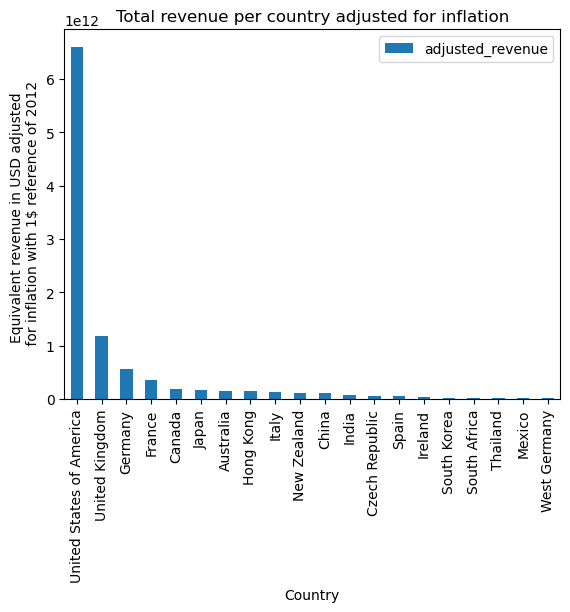

In [44]:
inflation_group = merged_all.groupby(["country"]).agg({"adjusted_revenue": "sum"})
inflation_group.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per country adjusted for inflation", xlabel="Country", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

In [45]:
# Top 20 countries that have generated the most total revenue
top_20_countries = inflation_group.sort_values(by="adjusted_revenue", ascending=False).head(20).index.values

<Axes: title={'center': 'Total revenue per language adjusted for inflation'}, xlabel='Language', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

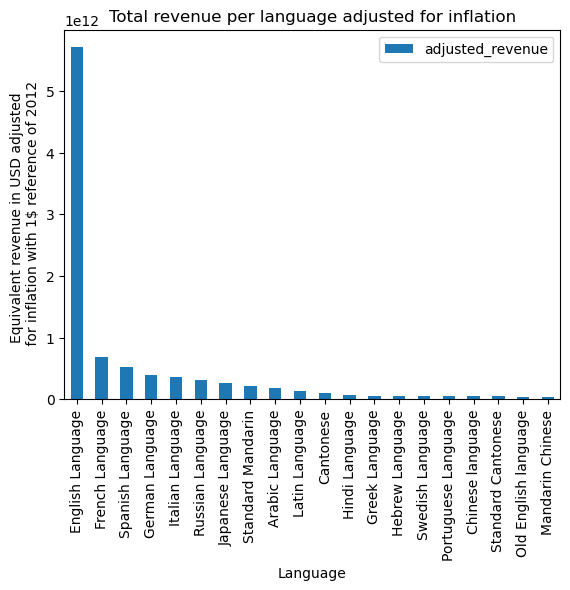

In [46]:
# plotting the average revenue per language adjusted for inflation
inflation_language_group = merged_all.groupby(["language"]).agg({"adjusted_revenue": "sum"})
inflation_language_group.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per language adjusted for inflation", xlabel="Language", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

Following the evolution over the years of the 20 countries that have generated the most total revenue

In [47]:
top_20_merged   = merged_all[merged_all["country"].isin(top_20_countries)]
top_20_merged.dropna(subset=["adjusted_revenue"], inplace=True)
top_20_grouped  = top_20_merged.groupby(["year", "country"])
top_20_sum      = top_20_grouped.agg({"adjusted_revenue": "sum"})

C:\Users\antho\AppData\Local\Temp\ipykernel_12992\1272405726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_merged.dropna(subset=["adjusted_revenue"], inplace=True)


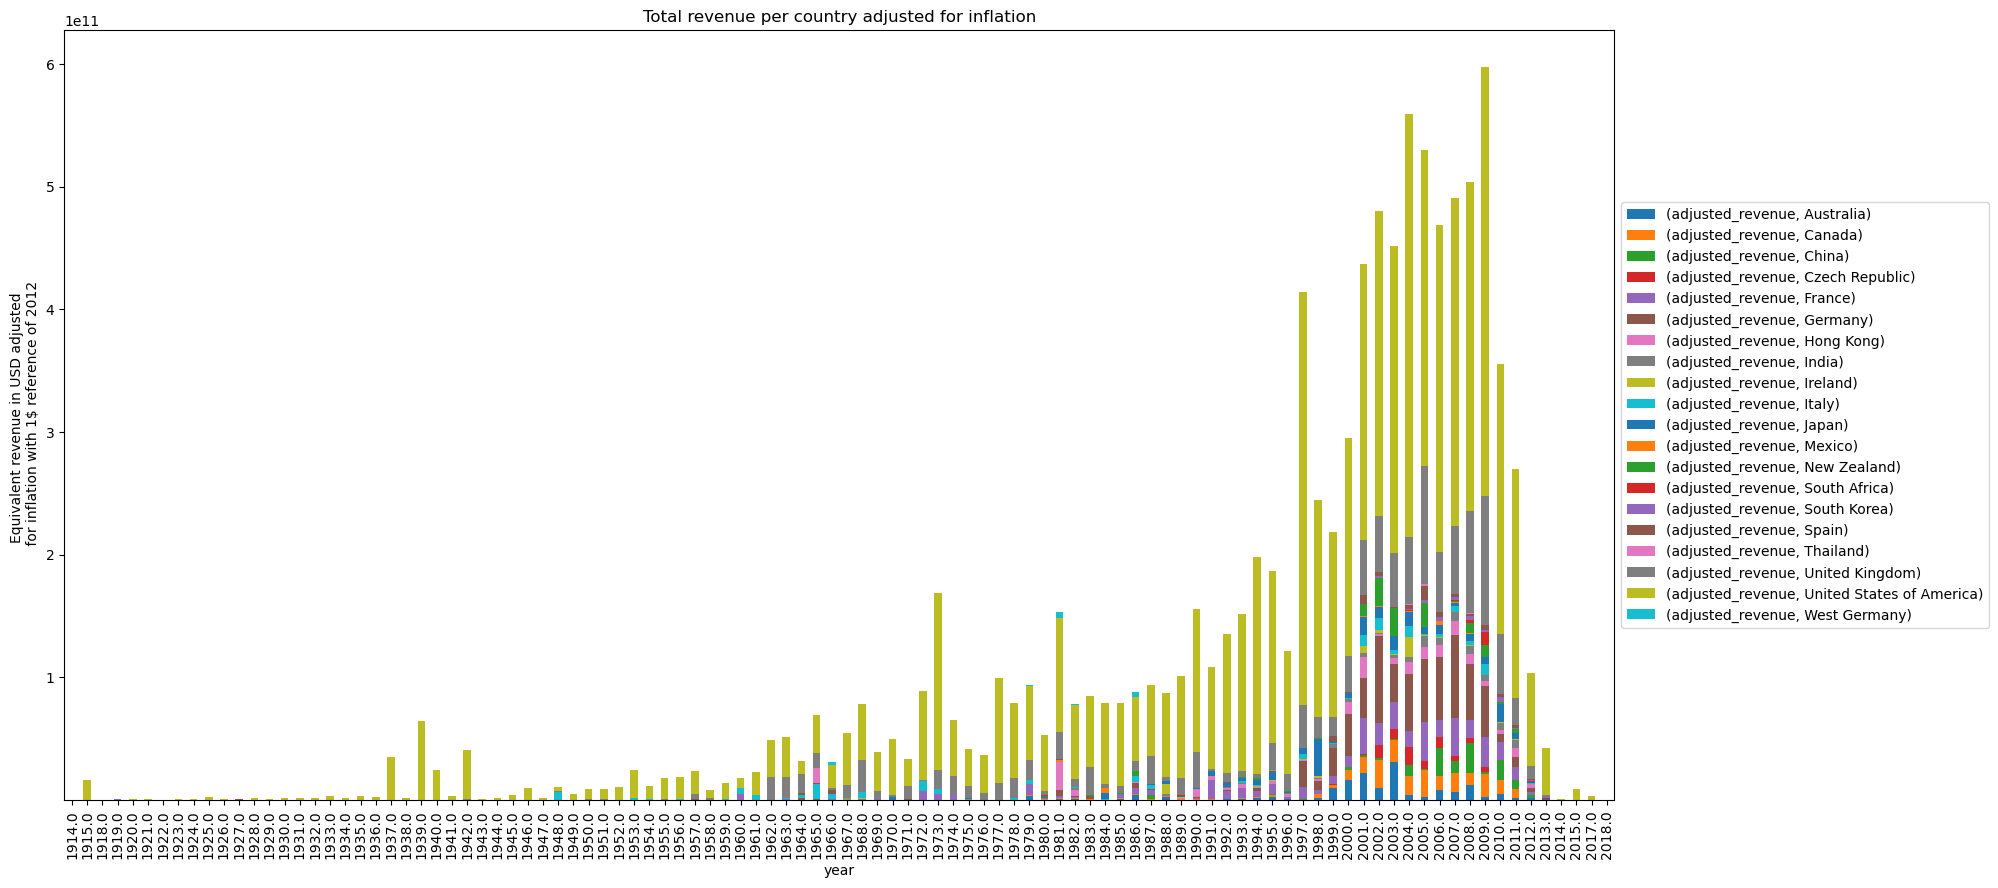

In [48]:
ax = top_20_sum.unstack().plot(kind='bar', stacked=True, title="Total revenue per country adjusted for inflation", xlabel="year", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012", figsize=(20,10))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We clearly see that globally, the movie industry has been making more money over the years. Though we see a drop during the years that follow 2008 which might be a consequence of the subprime's crisis.

The US dominance remains present even when looking at year-by-year movies revenue adjusted for inflation. The US has been the most productive country in terms of movies production and revenue generation for the past 100 years.

# Revenue analysis over the length of a movie

Aboout 35 movies have a runtime that is longer that 500 minutes, which does not make sense.

In [49]:
merged_all[merged_all["runtime"]>=500]["runtime"].describe()

count      35.000000
mean      609.742857
std       194.359331
min       544.000000
25%       544.000000
50%       544.000000
75%       544.000000
max      1440.000000
Name: runtime, dtype: float64

We can remove these outliers and perform a `pearson correlation` test between the `movie_runtime` and its `adjusted_revenue`

In [50]:
merged_with_inflation_no_outlier    = merged_all[merged_all["runtime"]<500]
non_nan_merged_with_inflation       = merged_with_inflation_no_outlier[~merged_with_inflation_no_outlier["adjusted_revenue"].isna()]
non_nan_merged_with_inflation       = non_nan_merged_with_inflation[~non_nan_merged_with_inflation["runtime"].isna()]
stats.pearsonr(non_nan_merged_with_inflation["runtime"], non_nan_merged_with_inflation["adjusted_revenue"])

PearsonRResult(statistic=0.21039178031692368, pvalue=0.0)

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.21` which indicates a weak positive correlation between `runtime` of a movie and its `adjusted_revenue`

c:\Users\antho\.conda\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Revenue vs Runtime')

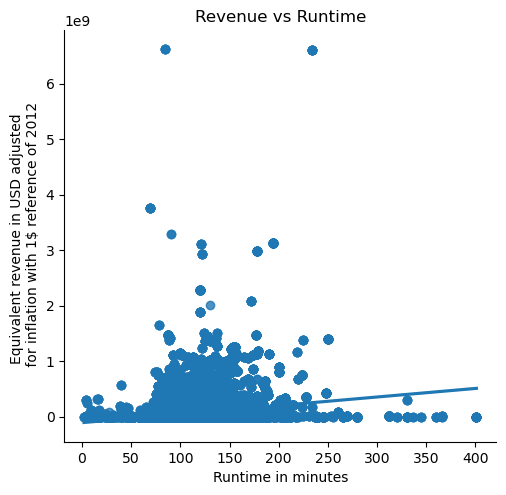

In [51]:
# plotting revenue vs runtime with a linear regression
sns.lmplot(x="runtime", y="adjusted_revenue", data=non_nan_merged_with_inflation)
plt.xlabel("Runtime in minutes")
plt.ylabel("Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")
plt.title("Revenue vs Runtime")

In [52]:
non_nan_merged_with_inflation["runtime"].describe()

count    164173.000000
mean        109.082704
std          24.073787
min           2.000000
25%          94.000000
50%         105.000000
75%         119.000000
max         401.000000
Name: runtime, dtype: float64

# Augmented data analysis

Plotting the 20 producers that have generated the most revenue over their carreer 

<Axes: title={'center': 'Total revenue per producer adjusted for inflation\n for top 20 generating producers'}, xlabel='Producer', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

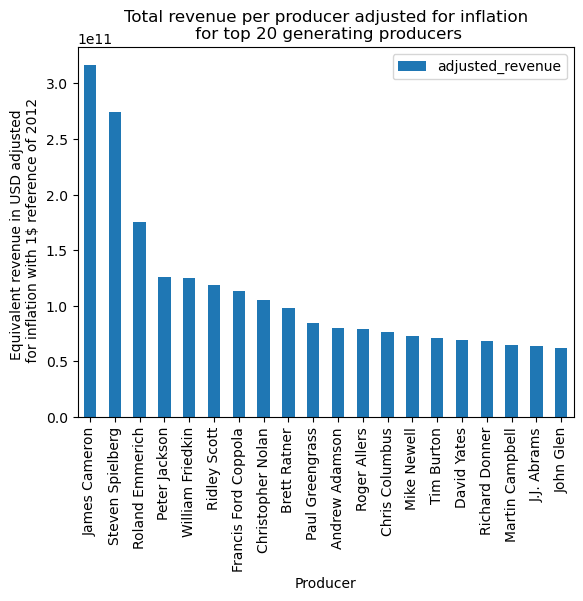

In [53]:
scraped_grouped = merged_all.groupby(["producer"]).agg({"adjusted_revenue": "sum"})
scraped_grouped.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per producer adjusted for inflation\n for top 20 generating producers", xlabel="Producer", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

`Adjusted Revenue` and `Rating` correlation analysis

<Axes: title={'center': 'Revenue vs Rating'}, xlabel='Rating', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

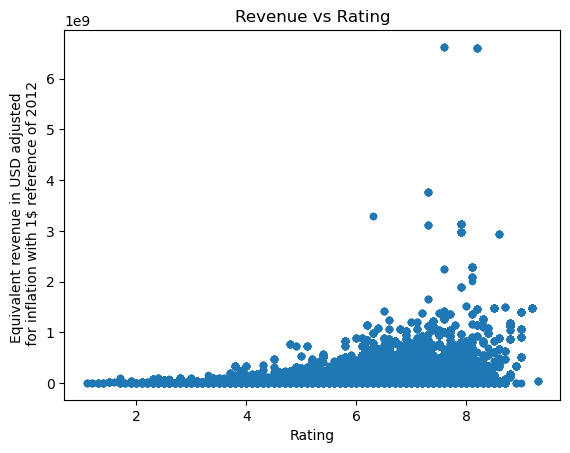

In [54]:
# plot revenue adjusted against rating score
merged_all.plot(kind="scatter", x="rating_score", y="adjusted_revenue", title="Revenue vs Rating", xlabel="Rating", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

In [55]:
non_nan_scraped_merge = merged_all[~merged_all["rating_score"].isna()]
non_nan_scraped_merge = non_nan_scraped_merge[~non_nan_scraped_merge["adjusted_revenue"].isna()]
stats.pearsonr(non_nan_scraped_merge["rating_score"], non_nan_scraped_merge["adjusted_revenue"])

PearsonRResult(statistic=0.14660418928605942, pvalue=0.0)

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.14` which indicates a weak positive correlation between `rating score` of a movie and its `adjusted revenue`

## 4) Movie budget

## 5) Genres

### Good movies

In [42]:
movies_good = df_good_movies.copy(deep=True)
movies_good.head()

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,opening_weekend,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score
36402,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/0gw5w78"": ""G...",36402,...,302393.0,9.2,2000000.0,65.0,Francis Ford Coppola,1972.0,1.473697e+09,0.922561,0.987805,95.518294
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3n2k"": ""Fantasy Adventure"", ""/m/03k9fj...",80920,...,72629713.0,9.0,1900000.0,248.0,Peter Jackson,2003.0,1.396402e+09,0.919786,0.963415,94.160040
80800,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03k9fj"": ""...",80800,...,1554475.0,8.6,1400000.0,342.0,George Lucas,1977.0,2.936845e+09,0.958077,0.914634,93.635538
38158,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/01jfsb"": ""Th...",38158,...,158411483.0,9.0,2800000.0,120.0,Christopher Nolan,2008.0,1.071109e+09,0.906127,0.963415,93.477078
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/060__y"": ""Film adaptation"", ""/m/04xvh5"": ...",37834,...,1192593.0,8.2,328000.0,922.0,Victor Fleming,1939.0,6.602256e+09,0.999799,0.865854,93.282644


In [43]:
def extract_json_values(df, column):
    """
    This function takes a dataframe and a column name containing JSON strings.
    It parses the JSON and preserves the content/values as a list of lists.
    """
    # Extract the values from each JSON object and append to a list
    values_list = []
    for json_str in df[column]:
        try:
            # Parse the JSON data
            json_data = json.loads(json_str)
            # Extract values and append to the list
            values_list.append(list(json_data.values()))
        except json.JSONDecodeError:
            # If JSON is not valid, append a None or handle it as needed
            values_list.append(None)
            
    return values_list

In [44]:
movies_good['genres'] = extract_json_values(movies_good, "genres")
movies_good.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,opening_weekend,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score
36402,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",36402,...,302393.0,9.2,2000000.0,65.0,Francis Ford Coppola,1972.0,1.473697e+09,0.922561,0.987805,95.518294
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",80920,...,72629713.0,9.0,1900000.0,248.0,Peter Jackson,2003.0,1.396402e+09,0.919786,0.963415,94.160040
80800,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",80800,...,1554475.0,8.6,1400000.0,342.0,George Lucas,1977.0,2.936845e+09,0.958077,0.914634,93.635538
38158,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",38158,...,158411483.0,9.0,2800000.0,120.0,Christopher Nolan,2008.0,1.071109e+09,0.906127,0.963415,93.477078
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",37834,...,1192593.0,8.2,328000.0,922.0,Victor Fleming,1939.0,6.602256e+09,0.999799,0.865854,93.282644
11063,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",11063,...,171417.0,9.0,1300000.0,408.0,Francis Ford Coppola,1974.0,8.986151e+08,0.897083,0.963415,93.024881
55873,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",55873,...,4910483.0,8.7,1400000.0,913.0,Irvin Kershner,1980.0,1.500162e+09,0.923478,0.926829,92.515349
8821,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",8821,...,62007528.0,8.8,1700000.0,643.0,Peter Jackson,2002.0,1.181213e+09,0.911167,0.939024,92.509546
79973,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",79973,...,47211490.0,8.8,2000000.0,143.0,Peter Jackson,2001.0,1.129462e+09,0.908859,0.939024,92.394173
65287,41528,/m/0bdjd,Forrest Gump,1994-06-23,6.773877e+08,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Coming of age, Comedy film, Drama, War film, ...",65287,...,24450602.0,8.8,2200000.0,266.0,Robert Zemeckis,1994.0,1.049520e+09,0.905078,0.939024,92.205129


In [45]:
# Assuming your DataFrame is named 'movies'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres = movies_good['genres']

# Create an empty dictionary to store genre counts
genres_counts = {}

# Iterate through each list of genres in the 'genres' column
for genres_list in genres:
    # Update the counts in the dictionary
    for genre in genres_list:
        genres_counts[genre] = genres_counts.get(genre, 0) + 1

# Convert the dictionary to a DataFrame for better visualization
genres_counts_df = pd.DataFrame(list(genres_counts.items()), columns=['Genre', 'Count'])

# Sort the DataFrame by the count in descending order
genres_counts_df = genres_counts_df.sort_values(by='Count', ascending=False)

# Display the result
genres_counts_df.head(362)

,Genre,Count
5,Drama,1817
44,Comedy,1013
19,Thriller,845
17,Action,775
26,Romance Film,749
...,...,...
182,Female buddy film,1
254,Horse racing,1
253,Point of view shot,1
235,Sci-Fi Thriller,1


In [46]:
# Assuming your DataFrame with genre counts is named 'genre_counts_df'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres_column = genres_counts_df['Genre']

# Define the genres of interest
primary_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 
                   'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction', 
                   'Sport', 'Thriller', 'War film']

# Create a dictionary to store the grouped genres and counts
grouped_genre_data = {'Primary Genre': [], 'Grouped Genres': [], 'Count': []}

# Group genres based on keywords
for primary_genre in primary_genres:
    # Find genres that contain the keyword
    grouped_genres = [genre for genre in genres_column if primary_genre.lower() in genre.lower()]
    
    # Sum the counts for the grouped genres
    grouped_count = genres_counts_df[genres_counts_df['Genre'].isin(grouped_genres)]['Count'].sum()
    
    # Add data to the dictionary
    grouped_genre_data['Primary Genre'].append(primary_genre)
    grouped_genre_data['Grouped Genres'].append(', '.join(grouped_genres))
    grouped_genre_data['Count'].append(grouped_count)

# Create a new DataFrame from the grouped data dictionary
grouped_genre_counts_df = pd.DataFrame(grouped_genre_data)

# Reorder the DataFrame
grouped_genre_counts_df = grouped_genre_counts_df.sort_values(by='Count', ascending=False)

# Display the result
grouped_genre_counts_df.head(18)

,Primary Genre,Grouped Genres,Count
5,Drama,"Drama, Romantic drama, Comedy-drama, Costume d...",2945
3,Comedy,"Comedy, Romantic comedy, Comedy-drama, Black c...",2009
0,Action,"Action, Action/Adventure, Action Thrillers, Ac...",1450
14,Thriller,"Thriller, Crime Thriller, Psychological thrill...",1395
1,Adventure,"Adventure, Action/Adventure, Fantasy Adventure...",1279
4,Crime,"Crime Fiction, Crime Thriller, Crime Drama, Cr...",869
11,Romance,Romance Film,749
6,Family,"Family Film, Children's/Family, Family Drama, ...",657
7,Fantasy,"Fantasy, Children's Fantasy, Fantasy Adventure...",531
8,Period piece,Period piece,322


In [47]:
movies_good['Generic Genre'] = np.nan
movies_good.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score,Generic Genre
36402,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",36402,...,9.2,2000000.0,65.0,Francis Ford Coppola,1972.0,1.473697e+09,0.922561,0.987805,95.518294,NaN
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",80920,...,9.0,1900000.0,248.0,Peter Jackson,2003.0,1.396402e+09,0.919786,0.963415,94.160040,NaN
80800,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",80800,...,8.6,1400000.0,342.0,George Lucas,1977.0,2.936845e+09,0.958077,0.914634,93.635538,NaN
38158,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",38158,...,9.0,2800000.0,120.0,Christopher Nolan,2008.0,1.071109e+09,0.906127,0.963415,93.477078,NaN
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",37834,...,8.2,328000.0,922.0,Victor Fleming,1939.0,6.602256e+09,0.999799,0.865854,93.282644,NaN
11063,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",11063,...,9.0,1300000.0,408.0,Francis Ford Coppola,1974.0,8.986151e+08,0.897083,0.963415,93.024881,NaN
55873,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",55873,...,8.7,1400000.0,913.0,Irvin Kershner,1980.0,1.500162e+09,0.923478,0.926829,92.515349,NaN
8821,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",8821,...,8.8,1700000.0,643.0,Peter Jackson,2002.0,1.181213e+09,0.911167,0.939024,92.509546,NaN
79973,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",79973,...,8.8,2000000.0,143.0,Peter Jackson,2001.0,1.129462e+09,0.908859,0.939024,92.394173,NaN
65287,41528,/m/0bdjd,Forrest Gump,1994-06-23,6.773877e+08,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Coming of age, Comedy film, Drama, War film, ...",65287,...,8.8,2200000.0,266.0,Robert Zemeckis,1994.0,1.049520e+09,0.905078,0.939024,92.205129,NaN


In [48]:
# Assuming 'movies' is your DataFrame
# If not, you need to define or read it before this point

# List of genres to create tables for
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']

# Define a function to get the list of genres for a movie
def get_genre_list(movie_genres):
    return [genre for genre in genres_list if any(genre.lower() in element.lower().strip() for element in movie_genres)]

# Apply the function to create the 'Generic Genre' column
movies_good['Generic Genre'] = movies_good['genres'].apply(get_genre_list)

movies_good.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score,Generic Genre
36402,2466773,/m/07g1sm,The Godfather,1972-03-15,2.685000e+08,177.0,"{""/m/04h9h"": ""Latin Language"", ""/m/02bjrlw"": ""...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Crime Drama, Fa...",36402,...,9.2,2000000.0,65.0,Francis Ford Coppola,1972.0,1.473697e+09,0.922561,0.987805,95.518294,"[Crime, Drama, Family, Period piece]"
80920,174251,/m/017jd9,The Lord of the Rings: The Return of the King,2003-12-17,1.119930e+09,250.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",80920,...,9.0,1900000.0,248.0,Peter Jackson,2003.0,1.396402e+09,0.919786,0.963415,94.160040,"[Action, Adventure, Drama, Fantasy]"
80800,52549,/m/0dtfn,Star Wars Episode IV: A New Hope,1977-05-25,7.753980e+08,122.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Fantasy, Coming o...",80800,...,8.6,1400000.0,342.0,George Lucas,1977.0,2.936845e+09,0.958077,0.914634,93.635538,"[Action, Adventure, Family, Fantasy, Science F..."
38158,4276475,/m/0btpm6,The Dark Knight,2008-07-16,1.004558e+09,153.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Crime Fiction, Thriller, Superhero movie, Cri...",38158,...,9.0,2800000.0,120.0,Christopher Nolan,2008.0,1.071109e+09,0.906127,0.963415,93.477078,"[Action, Adventure, Crime, Drama, Thriller]"
37834,2804704,/m/083skw,Gone with the Wind,1939-12-15,4.000000e+08,234.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Film adaptation, Costume drama, Roadshow thea...",37834,...,8.2,328000.0,922.0,Victor Fleming,1939.0,6.602256e+09,0.999799,0.865854,93.282644,"[Drama, Period piece, Romance, War film]"
11063,73875,/m/0jsf6,The Godfather Part II,1974-12-12,1.930000e+08,200.0,"{""/m/02bjrlw"": ""Italian Language"", ""/m/02h40lc...","{""/m/09c7w0"": ""United States of America""}","[Crime Fiction, Gangster Film, Drama, Crime Dr...",11063,...,9.0,1300000.0,408.0,Francis Ford Coppola,1974.0,8.986151e+08,0.897083,0.963415,93.024881,"[Crime, Drama]"
55873,53964,/m/0f3m1,Star Wars Episode V: The Empire Strikes Back,1980-05-21,5.383751e+08,124.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Adventure, Space opera, Fant...",55873,...,8.7,1400000.0,913.0,Irvin Kershner,1980.0,1.500162e+09,0.923478,0.926829,92.515349,"[Action, Adventure, Family, Fantasy, Science F..."
8821,173944,/m/017gm7,The Lord of the Rings: The Two Towers,2002-12-05,9.260471e+08,179.0,"{""/m/05p2d"": ""Old English language"", ""/m/02h40...","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Action/Ad...",8821,...,8.8,1700000.0,643.0,Peter Jackson,2002.0,1.181213e+09,0.911167,0.939024,92.509546,"[Action, Adventure, Drama, Fantasy]"
79973,173941,/m/017gl1,The Lord of the Rings: The Fellowship of the Ring,2001-12-10,8.715303e+08,178.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Fantasy Adventure, Adventure, Epic, Fantasy, ...",79973,...,8.8,2000000.0,143.0,Peter Jackson,2001.0,1.129462e+09,0.908859,0.939024,92.394173,"[Action, Adventure, Drama, Fantasy]"
65287,41528,/m/0bdjd,Forrest Gump,1994-06-23,6.773877e+08,136.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Coming of age, Comedy film, Drama, War film, ...",65287,...,8.8,2200000.0,266.0,Robert Zemeckis,1994.0,1.049520e+09,0.905078,0.939024,92.205129,"[Comedy, Drama, Romance, War film]"


In [49]:
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']
#for genre in genres_list: 
#    genre_movies = movies[movies['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
#   genre_movies.head(10)

genre_dataframes = {}

for genre in genres_list:
    genre_movies = movies_good[movies_good['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
    genre_dataframes[genre] = genre_movies

# Access specific genre DataFrames using genre names
action_movies = genre_dataframes['Action']
adventure_movies = genre_dataframes['Adventure']
animation_movies = genre_dataframes['Animation']
comedy_movies = genre_dataframes['Comedy']
crime_movies = genre_dataframes['Crime']
drama_movies = genre_dataframes['Drama']
family_movies = genre_dataframes['Family']
fantasy_movies = genre_dataframes['Fantasy']
period_piece_movies = genre_dataframes['Period piece']
horror_movies = genre_dataframes['Horror']
musical_movies = genre_dataframes['Musical']
romance_movies = genre_dataframes['Romance']
scifi_movies = genre_dataframes['Science Fiction']
sport_movies = genre_dataframes['Sport']
thriller_movies = genre_dataframes['Thriller']
war_movies = genre_dataframes['War film']

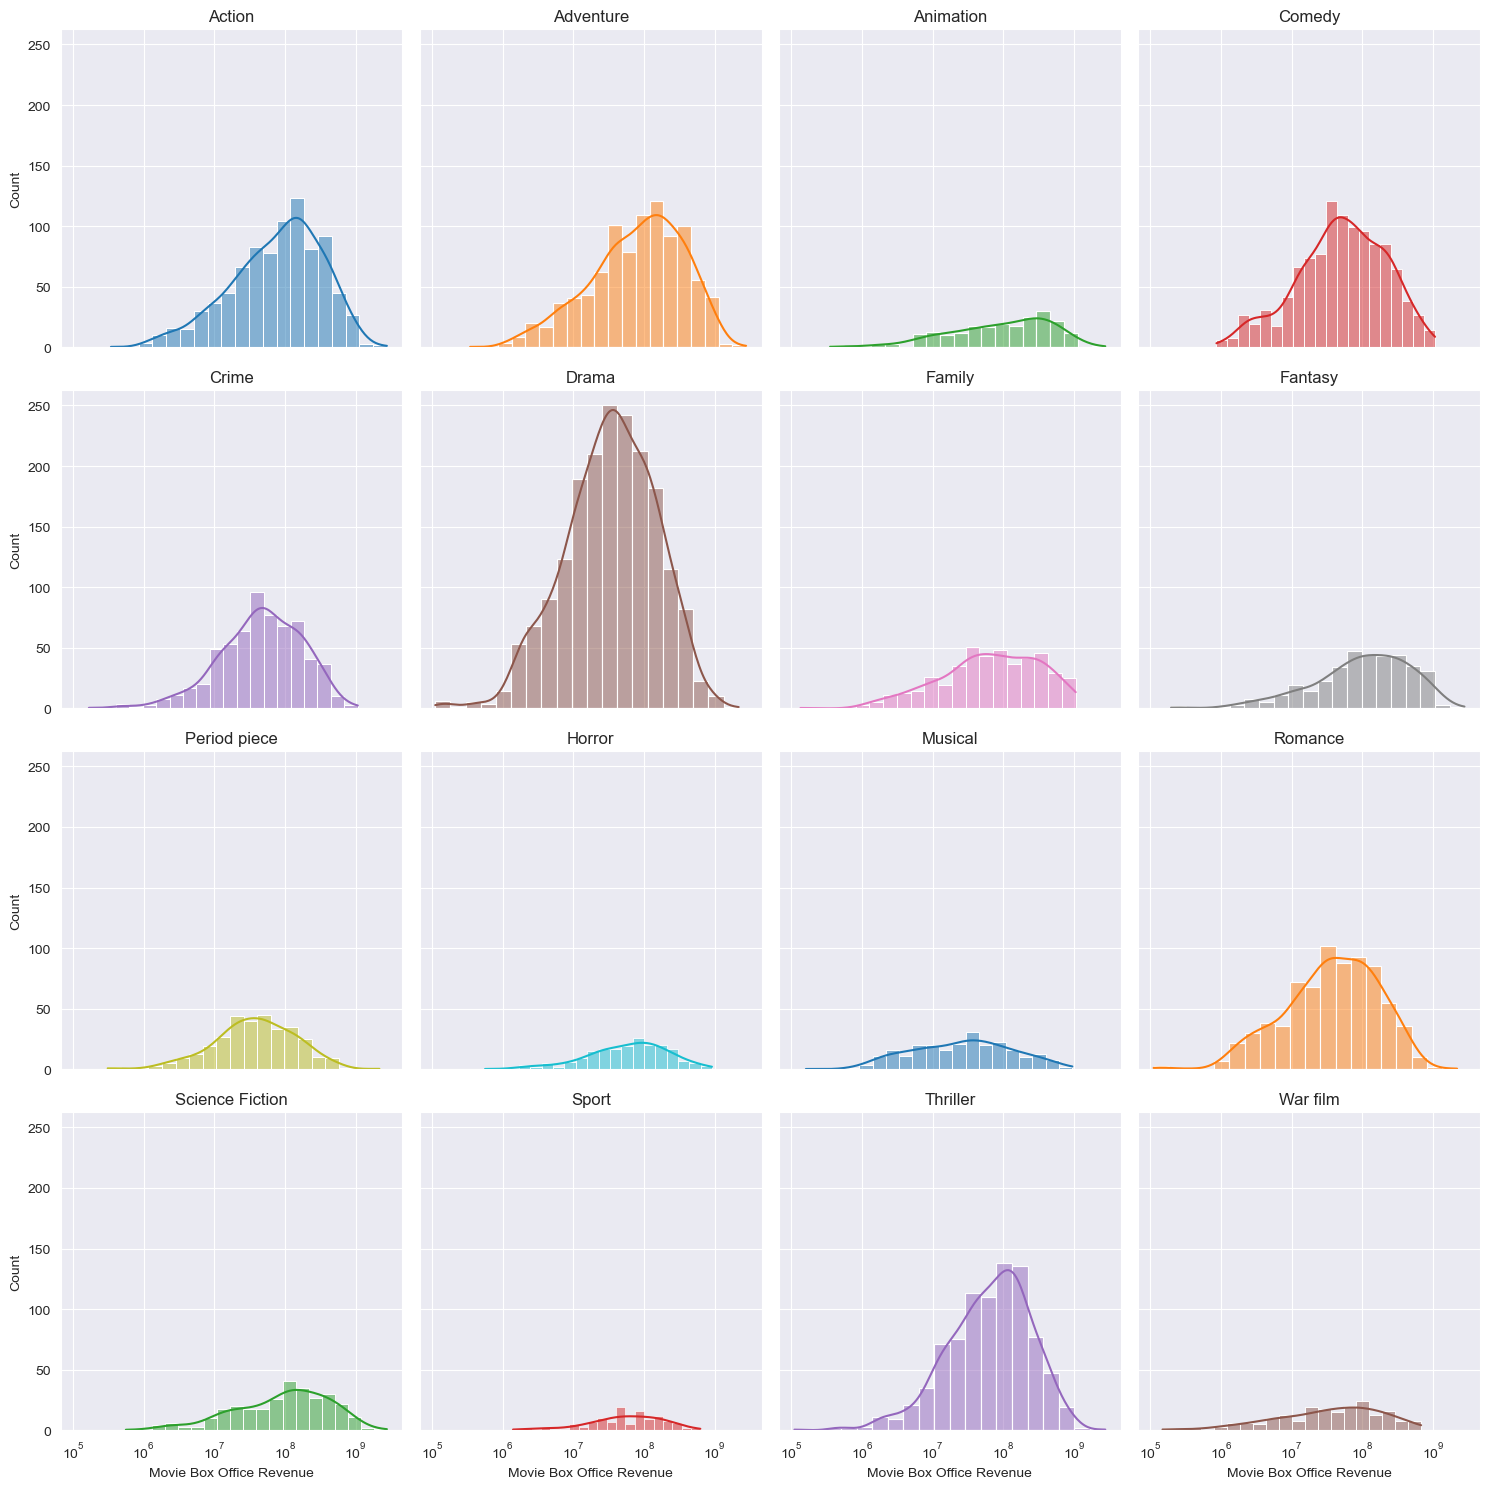

In [50]:
# Assuming 'genre_dataframes' is the dictionary of genre-specific DataFrames

# Create a 4x4 subplot grid for all genres except 'Action'
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the genres (excluding 'Action') and corresponding DataFrames
for i, (genre, genre_df) in enumerate(genre_dataframes.items()):
    if genre != 'Action':
        plt.xscale("log")
        # Plot the distribution of movie revenue for each genre
        sns.histplot(ax=axes[i], data=genre_df, x='revenue', kde=True, bins=20, color='C{}'.format(i))
        axes[i].set_title(genre)
        axes[i].set_xlabel('Movie Box Office Revenue')
        axes[i].set_ylabel('Count')

# Plot 'Action' genre in the middle of the 5th row, 16th subplot
action_df = genre_dataframes['Action']
# Set x-axis to log scale for the 'Action' subplot
axes[0].set_xscale('log')
sns.histplot(ax=axes[0], data=action_df, x='revenue', kde=True, bins=20)
axes[0].set_title('Action')
axes[0].set_xlabel('Movie Box Office Revenue')
axes[0].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [51]:
# Revenue statistics per genre
# Create empty dictionaries to store statistics for each genre
genre_stats = {'Mean': {}, 'Median': {}, 'Maximum': {}, 'Minimum': {}}

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    mean_revenue = genre_df['revenue'].mean()
    median_revenue = genre_df['revenue'].median()
    max_revenue = genre_df['revenue'].max()
    min_revenue = genre_df['revenue'].min()

    # Store the results in the dictionaries
    genre_stats['Mean'][genre] = mean_revenue
    genre_stats['Median'][genre] = median_revenue
    genre_stats['Maximum'][genre] = max_revenue
    genre_stats['Minimum'][genre] = min_revenue

# For easy displays, convert the dictionaries to Pandas DataFrames 
mean_df = pd.DataFrame(genre_stats['Mean'], index=['Mean Revenue'])
median_df = pd.DataFrame(genre_stats['Median'], index=['Median Revenue'])
max_df = pd.DataFrame(genre_stats['Maximum'], index=['Maximum Revenue'])
min_df = pd.DataFrame(genre_stats['Minimum'], index=['Minimum Revenue'])

# Concatenate the DataFrames along the columns to create a general DataFrame
general_stats_df = pd.concat([mean_df, median_df, max_df, min_df])

# Display the summary DataFrame
general_stats_df.head(10)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Period piece,Horror,Musical,Romance,Science Fiction,Sport,Thriller,War film
Mean Revenue,1.762634e+08,1.875924e+08,2.263777e+08,1.170605e+08,9.530101e+07,8.454735e+07,1.738861e+08,2.352302e+08,8.370068e+07,1.149584e+08,7.934243e+07,9.034620e+07,2.146921e+08,96198137.3,1.331398e+08,9.264287e+07
Median Revenue,9.527566e+07,9.618890e+07,1.171951e+08,5.370000e+07,4.842434e+07,3.500000e+07,7.455798e+07,1.195850e+08,4.005259e+07,6.962371e+07,3.043224e+07,4.047166e+07,1.122970e+08,56387498.5,7.418968e+07,4.356088e+07
Maximum Revenue,2.782275e+09,2.782275e+09,2.782275e+09,1.066180e+09,1.078009e+09,2.185372e+09,1.063172e+09,2.782275e+09,2.185372e+09,9.146911e+08,9.515838e+08,2.185372e+09,2.782275e+09,626100000.0,2.782275e+09,6.773877e+08
Minimum Revenue,3.462580e+05,3.462580e+05,3.553950e+05,8.610000e+05,1.686900e+05,1.110550e+05,1.353420e+05,1.963750e+05,3.112120e+05,5.627110e+05,1.614340e+05,1.110550e+05,5.627110e+05,1400000.0,1.110550e+05,1.485030e+05


In [52]:
# Identify which genre has the highest and lowest values for each statistic
# Mean 
highest_mean_genre = general_stats_df.loc['Mean Revenue'].idxmax()
lowest_mean_genre = general_stats_df.loc['Mean Revenue'].idxmin()

# Display the results
print(f"Highest Mean Revenue Genre: {highest_mean_genre}")
print(f"Lowest Mean Revenue Genre: {lowest_mean_genre}")

Highest Mean Revenue Genre: Fantasy
Lowest Mean Revenue Genre: Musical


In [53]:
# Median
highest_median_genre = general_stats_df.loc['Median Revenue'].idxmax()
lowest_median_genre = general_stats_df.loc['Median Revenue'].idxmin()

print(f"Highest Median Revenue Genre: {highest_median_genre}")
print(f"Lowest Median Revenue Genre: {lowest_median_genre}")

Highest Median Revenue Genre: Fantasy
Lowest Median Revenue Genre: Musical


In [54]:
# Max
highest_max_genre = general_stats_df.loc['Maximum Revenue'].idxmax()
lowest_max_genre = general_stats_df.loc['Maximum Revenue'].idxmin()

print(f"Highest Maximum Revenue Genre: {highest_max_genre}")
print(f"Lowest Maximum Revenue Genre: {lowest_max_genre}")

Highest Maximum Revenue Genre: Action
Lowest Maximum Revenue Genre: Sport


In [55]:
# Min
highest_min_genre = general_stats_df.loc['Minimum Revenue'].idxmax()
lowest_min_genre = general_stats_df.loc['Minimum Revenue'].idxmin()

print(f"Highest Minimum Revenue Genre: {highest_min_genre}")
print(f"Lowest Minimum Revenue Genre: {lowest_min_genre}")

Highest Minimum Revenue Genre: Sport
Lowest Minimum Revenue Genre: Drama


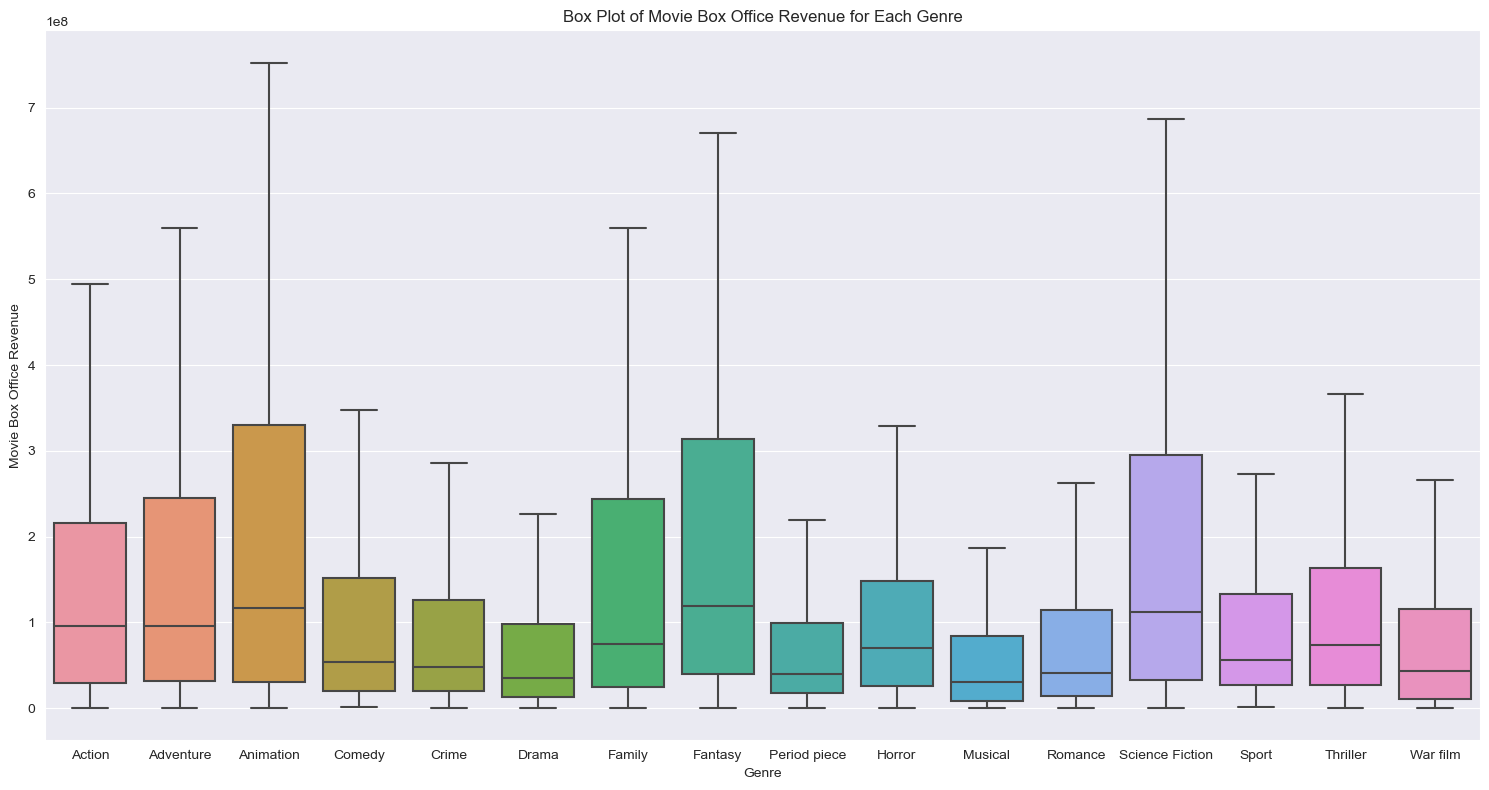

In [56]:
# Create a list to store DataFrames for box plots
boxplot_genre_dfs = []

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    # Use .copy() to create a copy and add a 'Genre' column
    genre_df_copy = genre_df.copy()
    genre_df_copy['Genre'] = genre
    boxplot_genre_dfs.append(genre_df_copy[['revenue', 'Genre']])


# Concatenate the DataFrames along the rows for box plot
boxplot_concat = pd.concat(boxplot_genre_dfs)

# Create a box plot using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Genre', y='revenue', data=boxplot_concat, showfliers=False)
plt.title('Box Plot of Movie Box Office Revenue for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Movie Box Office Revenue')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

### Bad movies

In [57]:
movies_bad = df_bad_movies.copy(deep=True)
movies_bad.head()

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,opening_weekend,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score
607,1851703,/m/060__7,Snow Falling on Cedars,1999-09-12,23049593.0,125.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",607,...,32135.0,6.7,14000.0,NaN,Scott Hicks,1999.0,3.175162e+07,0.724908,0.682927,70.391724
47076,240376,/m/01jw83,Only When I Laugh,1981-09-23,25524778.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/01t_vv"": ""C...",47076,...,NaN,6.4,1600.0,NaN,Glenn Jordan,1981.0,6.448216e+07,0.761396,0.646341,70.386865
7404,33757147,/m/0gxtknx,Seven Psychopaths,2012-09-07,12290017.0,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01z4y"": ""Comedy""}",7404,...,4174915.0,7.1,270000.0,2747.0,Martin McDonagh,2012.0,1.229002e+07,0.676022,0.731707,70.386452
19135,689980,/m/032_yq,Mercury Rising,1998-04-03,93107289.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...",19135,...,10104715.0,6.1,77000.0,NaN,Harold Becker,1998.0,1.310802e+08,0.797934,0.609756,70.384519
8552,4403560,/m/0c0d9s,Clockers,1995-09-13,13071518.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",8552,...,4463560.0,6.9,23000.0,NaN,Spike Lee,1995.0,1.970090e+07,0.700326,0.707317,70.382132


In [58]:
def extract_json_values(df, column):
    """
    This function takes a dataframe and a column name containing JSON strings.
    It parses the JSON and preserves the content/values as a list of lists.
    """
    # Extract the values from each JSON object and append to a list
    values_list = []
    for json_str in df[column]:
        try:
            # Parse the JSON data
            json_data = json.loads(json_str)
            # Extract values and append to the list
            values_list.append(list(json_data.values()))
        except json.JSONDecodeError:
            # If JSON is not valid, append a None or handle it as needed
            values_list.append(None)
            
    return values_list

In [59]:
movies_bad['genres'] = extract_json_values(movies_bad, "genres")
movies_bad.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,opening_weekend,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score
607,1851703,/m/060__7,Snow Falling on Cedars,1999-09-12,23049593.0,125.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Mystery, Period piec...",607,...,32135.0,6.7,14000.0,NaN,Scott Hicks,1999.0,3.175162e+07,0.724908,0.682927,70.391724
47076,240376,/m/01jw83,Only When I Laugh,1981-09-23,25524778.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Family Drama, Comedy-drama]",47076,...,NaN,6.4,1600.0,NaN,Glenn Jordan,1981.0,6.448216e+07,0.761396,0.646341,70.386865
7404,33757147,/m/0gxtknx,Seven Psychopaths,2012-09-07,12290017.0,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",[Comedy],7404,...,4174915.0,7.1,270000.0,2747.0,Martin McDonagh,2012.0,1.229002e+07,0.676022,0.731707,70.386452
19135,689980,/m/032_yq,Mercury Rising,1998-04-03,93107289.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Action/Adventure, Action, Suspense,...",19135,...,10104715.0,6.1,77000.0,NaN,Harold Becker,1998.0,1.310802e+08,0.797934,0.609756,70.384519
8552,4403560,/m/0c0d9s,Clockers,1995-09-13,13071518.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Crime Drama, Coming ...",8552,...,4463560.0,6.9,23000.0,NaN,Spike Lee,1995.0,1.970090e+07,0.700326,0.707317,70.382132
9358,4515932,/m/0c6mr2,Ghost in the Shell: Solid State Society,2006-09-01,2055431.0,109.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","[Thriller, Science Fiction, Japanese Movies, W...",9358,...,NaN,7.8,7400.0,NaN,Kenji Kamiyama,2006.0,2.338578e+06,0.590563,0.817073,70.381809
30265,8856075,/m/027m5wv,The Shipping News,2001-12-25,24405825.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic drama, Romance Film, Drama, Film ada...",30265,...,1205174.0,6.7,34000.0,NaN,Lasse Hallström,2001.0,3.162878e+07,0.724708,0.682927,70.381742
73722,14429341,/m/03d37y7,The Best Little Whorehouse in Texas,1982-07-23,69701637.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic comedy, LGBT, Sex comedy, Musical co...",73722,...,11874268.0,6.0,13000.0,NaN,Colin Higgins,1982.0,1.658044e+08,0.810038,0.597561,70.379940
75719,690918,/m/0333gq,The Entity,1982-09-30,13277558.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Supernatur...",75719,...,3685654.0,6.7,18000.0,NaN,Sidney J. Furie,1982.0,3.158430e+07,0.724636,0.682927,70.378118
27145,23086136,/m/064ppgg,Men in War,1957-03-19,1500000.0,104.0,{},"{""/m/09c7w0"": ""United States of America""}","[Black-and-white, Action/Adventure, Western, D...",27145,...,NaN,7.1,2900.0,NaN,Anthony Mann,1957.0,1.224344e+07,0.675826,0.731707,70.376674


In [60]:
# Assuming your DataFrame is named 'movies'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres = movies_bad['genres']

# Create an empty dictionary to store genre counts
genres_counts = {}

# Iterate through each list of genres in the 'genres' column
for genres_list in genres:
    # Update the counts in the dictionary
    for genre in genres_list:
        genres_counts[genre] = genres_counts.get(genre, 0) + 1

# Convert the dictionary to a DataFrame for better visualization
genres_counts_df = pd.DataFrame(list(genres_counts.items()), columns=['Genre', 'Count'])

# Sort the DataFrame by the count in descending order
genres_counts_df = genres_counts_df.sort_values(by='Count', ascending=False)

# Display the result
genres_counts_df.head(362)

,Genre,Count
4,Drama,4827
11,Comedy,3115
7,Romance Film,2085
0,Thriller,1840
21,World cinema,1491
...,...,...
273,Outlaw biker film,1
276,School story,1
277,Kafkaesque,1
278,Cyberpunk,1


In [61]:
# Assuming your DataFrame with genre counts is named 'genre_counts_df'
# Replace 'YourColumnName' with the actual column name in your DataFrame
genres_column = genres_counts_df['Genre']

# Define the genres of interest
primary_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family', 
                   'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction', 
                   'Sport', 'Thriller', 'War film']

# Create a dictionary to store the grouped genres and counts
grouped_genre_data = {'Primary Genre': [], 'Grouped Genres': [], 'Count': []}

# Group genres based on keywords
for primary_genre in primary_genres:
    # Find genres that contain the keyword
    grouped_genres = [genre for genre in genres_column if primary_genre.lower() in genre.lower()]
    
    # Sum the counts for the grouped genres
    grouped_count = genres_counts_df[genres_counts_df['Genre'].isin(grouped_genres)]['Count'].sum()
    
    # Add data to the dictionary
    grouped_genre_data['Primary Genre'].append(primary_genre)
    grouped_genre_data['Grouped Genres'].append(', '.join(grouped_genres))
    grouped_genre_data['Count'].append(grouped_count)

# Create a new DataFrame from the grouped data dictionary
grouped_genre_counts_df = pd.DataFrame(grouped_genre_data)

# Reorder the DataFrame
grouped_genre_counts_df = grouped_genre_counts_df.sort_values(by='Count', ascending=False)

# Display the result
grouped_genre_counts_df.head(18)

,Primary Genre,Grouped Genres,Count
5,Drama,"Drama, Romantic drama, Comedy-drama, Family Dr...",7276
3,Comedy,"Comedy, Romantic comedy, Comedy-drama, Comedy ...",6118
14,Thriller,"Thriller, Crime Thriller, Psychological thrill...",2955
0,Action,"Action, Action/Adventure, Action Thrillers, Ac...",2599
11,Romance,Romance Film,2085
1,Adventure,"Action/Adventure, Adventure, Family-Oriented A...",1960
4,Crime,"Crime Fiction, Crime Thriller, Crime Drama, Cr...",1878
6,Family,"Family Film, Family Drama, Children's/Family, ...",1171
9,Horror,"Horror, Horror Comedy, Natural horror films, S...",986
7,Fantasy,"Fantasy, Fantasy Comedy, Fantasy Adventure, Ch...",765


In [62]:
movies_bad['Generic Genre'] = np.nan
movies_bad.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score,Generic Genre
607,1851703,/m/060__7,Snow Falling on Cedars,1999-09-12,23049593.0,125.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Mystery, Period piec...",607,...,6.7,14000.0,NaN,Scott Hicks,1999.0,3.175162e+07,0.724908,0.682927,70.391724,NaN
47076,240376,/m/01jw83,Only When I Laugh,1981-09-23,25524778.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Family Drama, Comedy-drama]",47076,...,6.4,1600.0,NaN,Glenn Jordan,1981.0,6.448216e+07,0.761396,0.646341,70.386865,NaN
7404,33757147,/m/0gxtknx,Seven Psychopaths,2012-09-07,12290017.0,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",[Comedy],7404,...,7.1,270000.0,2747.0,Martin McDonagh,2012.0,1.229002e+07,0.676022,0.731707,70.386452,NaN
19135,689980,/m/032_yq,Mercury Rising,1998-04-03,93107289.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Action/Adventure, Action, Suspense,...",19135,...,6.1,77000.0,NaN,Harold Becker,1998.0,1.310802e+08,0.797934,0.609756,70.384519,NaN
8552,4403560,/m/0c0d9s,Clockers,1995-09-13,13071518.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Crime Drama, Coming ...",8552,...,6.9,23000.0,NaN,Spike Lee,1995.0,1.970090e+07,0.700326,0.707317,70.382132,NaN
9358,4515932,/m/0c6mr2,Ghost in the Shell: Solid State Society,2006-09-01,2055431.0,109.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","[Thriller, Science Fiction, Japanese Movies, W...",9358,...,7.8,7400.0,NaN,Kenji Kamiyama,2006.0,2.338578e+06,0.590563,0.817073,70.381809,NaN
30265,8856075,/m/027m5wv,The Shipping News,2001-12-25,24405825.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic drama, Romance Film, Drama, Film ada...",30265,...,6.7,34000.0,NaN,Lasse Hallström,2001.0,3.162878e+07,0.724708,0.682927,70.381742,NaN
73722,14429341,/m/03d37y7,The Best Little Whorehouse in Texas,1982-07-23,69701637.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic comedy, LGBT, Sex comedy, Musical co...",73722,...,6.0,13000.0,NaN,Colin Higgins,1982.0,1.658044e+08,0.810038,0.597561,70.379940,NaN
75719,690918,/m/0333gq,The Entity,1982-09-30,13277558.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Supernatur...",75719,...,6.7,18000.0,NaN,Sidney J. Furie,1982.0,3.158430e+07,0.724636,0.682927,70.378118,NaN
27145,23086136,/m/064ppgg,Men in War,1957-03-19,1500000.0,104.0,{},"{""/m/09c7w0"": ""United States of America""}","[Black-and-white, Action/Adventure, Western, D...",27145,...,7.1,2900.0,NaN,Anthony Mann,1957.0,1.224344e+07,0.675826,0.731707,70.376674,NaN


In [63]:
# Assuming 'movies' is your DataFrame
# If not, you need to define or read it before this point

# List of genres to create tables for
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']

# Define a function to get the list of genres for a movie
def get_genre_list(movie_genres):
    return [genre for genre in genres_list if any(genre.lower() in element.lower().strip() for element in movie_genres)]

# Apply the function to create the 'Generic Genre' column
movies_bad['Generic Genre'] = movies_bad['genres'].apply(get_genre_list)

movies_bad.head(10)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,...,movie_rating,number_of_ratings,watched_rank,producer,year,adjusted_revenue,borc,rc,movie_score,Generic Genre
607,1851703,/m/060__7,Snow Falling on Cedars,1999-09-12,23049593.0,125.0,"{""/m/03_9r"": ""Japanese Language"", ""/m/04306rv""...","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Mystery, Period piec...",607,...,6.7,14000.0,NaN,Scott Hicks,1999.0,3.175162e+07,0.724908,0.682927,70.391724,"[Crime, Drama, Period piece, Romance, Thriller]"
47076,240376,/m/01jw83,Only When I Laugh,1981-09-23,25524778.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Family Drama, Comedy-drama]",47076,...,6.4,1600.0,NaN,Glenn Jordan,1981.0,6.448216e+07,0.761396,0.646341,70.386865,"[Comedy, Drama, Family]"
7404,33757147,/m/0gxtknx,Seven Psychopaths,2012-09-07,12290017.0,109.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",[Comedy],7404,...,7.1,270000.0,2747.0,Martin McDonagh,2012.0,1.229002e+07,0.676022,0.731707,70.386452,[Comedy]
19135,689980,/m/032_yq,Mercury Rising,1998-04-03,93107289.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Action/Adventure, Action, Suspense,...",19135,...,6.1,77000.0,NaN,Harold Becker,1998.0,1.310802e+08,0.797934,0.609756,70.384519,"[Action, Adventure, Thriller]"
8552,4403560,/m/0c0d9s,Clockers,1995-09-13,13071518.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Crime Fiction, Crime Drama, Coming ...",8552,...,6.9,23000.0,NaN,Spike Lee,1995.0,1.970090e+07,0.700326,0.707317,70.382132,"[Crime, Drama, Thriller]"
9358,4515932,/m/0c6mr2,Ghost in the Shell: Solid State Society,2006-09-01,2055431.0,109.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","[Thriller, Science Fiction, Japanese Movies, W...",9358,...,7.8,7400.0,NaN,Kenji Kamiyama,2006.0,2.338578e+06,0.590563,0.817073,70.381809,"[Action, Adventure, Animation, Science Fiction..."
30265,8856075,/m/027m5wv,The Shipping News,2001-12-25,24405825.0,111.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic drama, Romance Film, Drama, Film ada...",30265,...,6.7,34000.0,NaN,Lasse Hallström,2001.0,3.162878e+07,0.724708,0.682927,70.381742,"[Drama, Romance]"
73722,14429341,/m/03d37y7,The Best Little Whorehouse in Texas,1982-07-23,69701637.0,114.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic comedy, LGBT, Sex comedy, Musical co...",73722,...,6.0,13000.0,NaN,Colin Higgins,1982.0,1.658044e+08,0.810038,0.597561,70.379940,"[Comedy, Musical, Romance]"
75719,690918,/m/0333gq,The Entity,1982-09-30,13277558.0,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Supernatur...",75719,...,6.7,18000.0,NaN,Sidney J. Furie,1982.0,3.158430e+07,0.724636,0.682927,70.378118,"[Drama, Fantasy, Horror, Science Fiction, Thri..."
27145,23086136,/m/064ppgg,Men in War,1957-03-19,1500000.0,104.0,{},"{""/m/09c7w0"": ""United States of America""}","[Black-and-white, Action/Adventure, Western, D...",27145,...,7.1,2900.0,NaN,Anthony Mann,1957.0,1.224344e+07,0.675826,0.731707,70.376674,"[Action, Adventure, Drama, War film]"


In [64]:
genres_list = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Drama', 'Family',
               'Fantasy', 'Period piece', 'Horror', 'Musical', 'Romance', 'Science Fiction',
               'Sport', 'Thriller', 'War film']
#for genre in genres_list: 
#    genre_movies = movies[movies['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
#   genre_movies.head(10)

genre_dataframes = {}

for genre in genres_list:
    genre_movies = movies_bad[movies_bad['Generic Genre'].apply(lambda x: genre in x if x is not None else False)]
    genre_dataframes[genre] = genre_movies

# Access specific genre DataFrames using genre names
action_movies = genre_dataframes['Action']
adventure_movies = genre_dataframes['Adventure']
animation_movies = genre_dataframes['Animation']
comedy_movies = genre_dataframes['Comedy']
crime_movies = genre_dataframes['Crime']
drama_movies = genre_dataframes['Drama']
family_movies = genre_dataframes['Family']
fantasy_movies = genre_dataframes['Fantasy']
period_piece_movies = genre_dataframes['Period piece']
horror_movies = genre_dataframes['Horror']
musical_movies = genre_dataframes['Musical']
romance_movies = genre_dataframes['Romance']
scifi_movies = genre_dataframes['Science Fiction']
sport_movies = genre_dataframes['Sport']
thriller_movies = genre_dataframes['Thriller']
war_movies = genre_dataframes['War film']

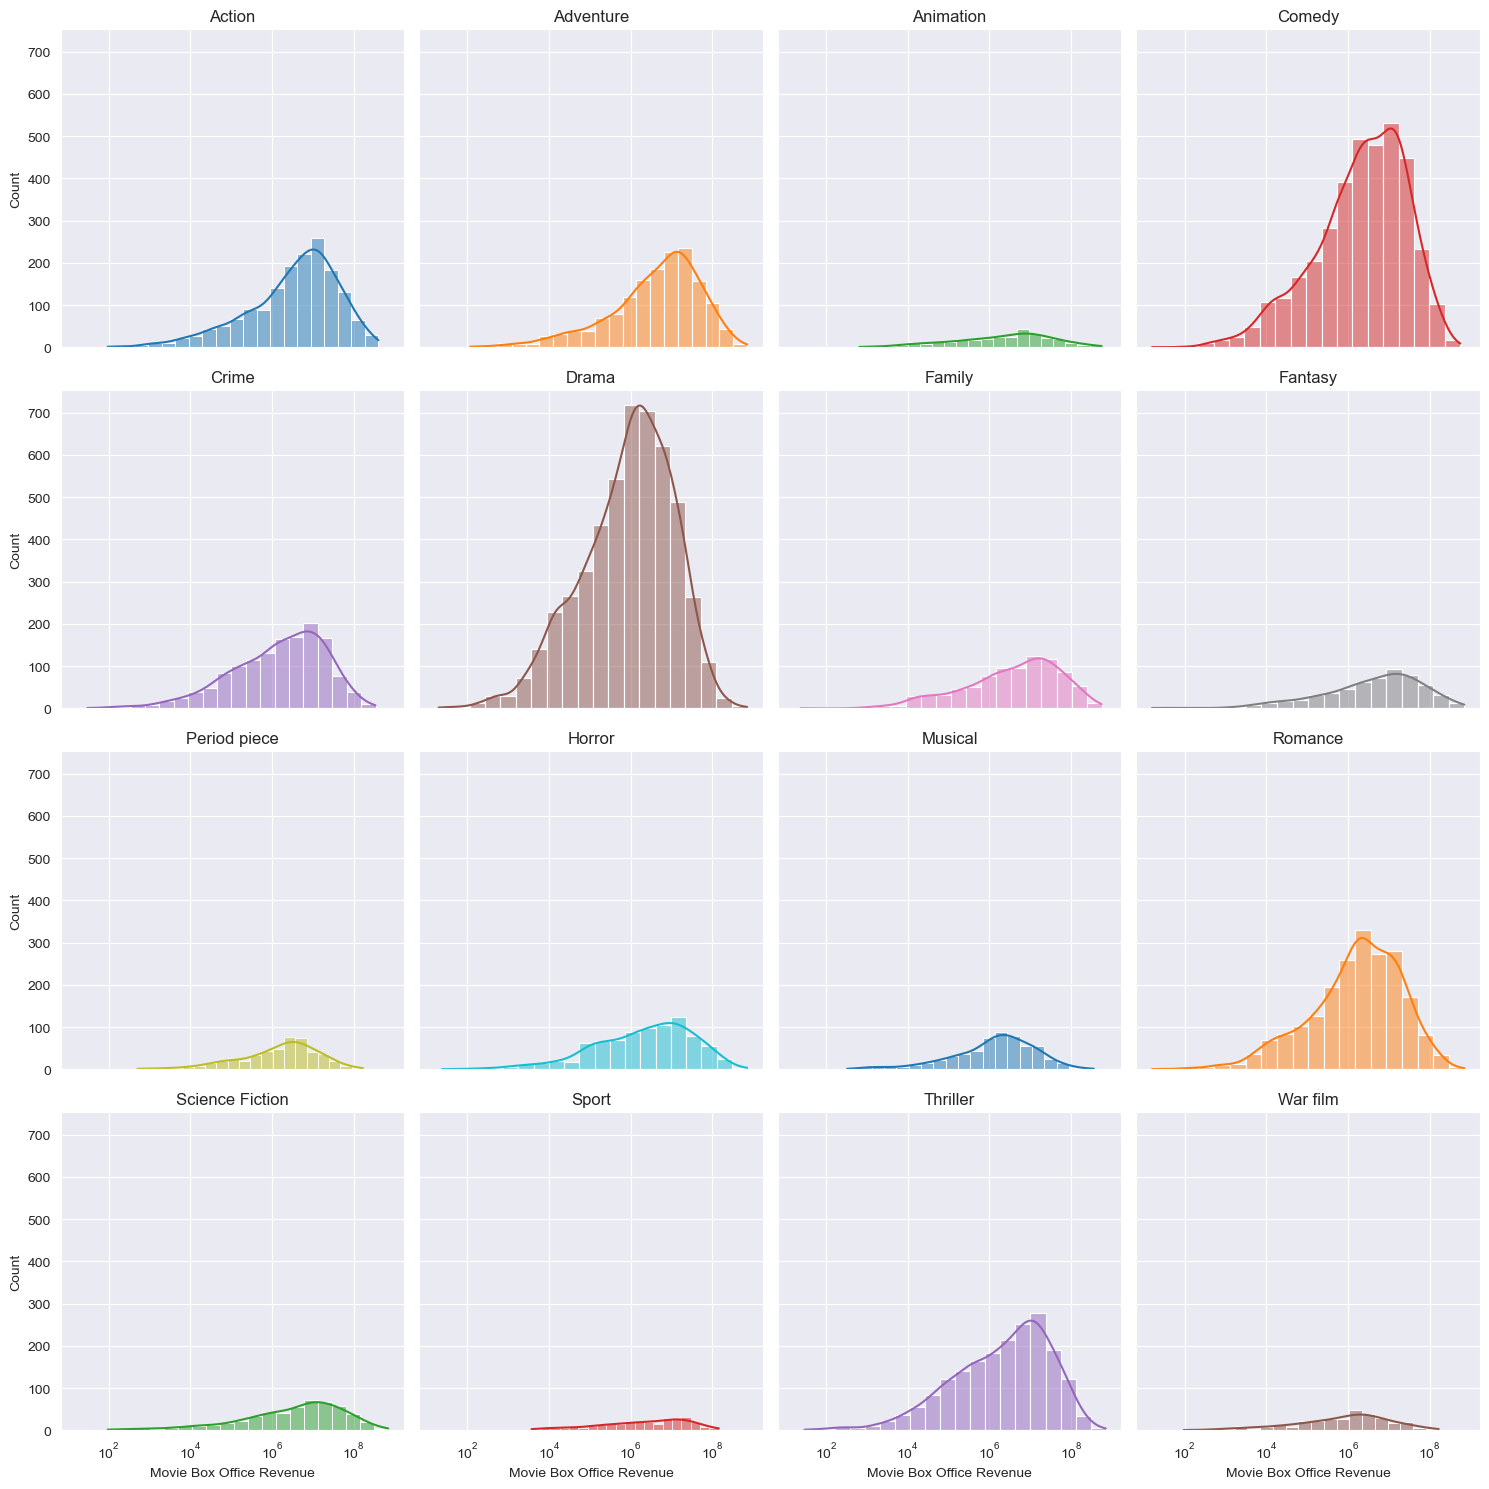

In [65]:
# Assuming 'genre_dataframes' is the dictionary of genre-specific DataFrames

# Create a 4x4 subplot grid for all genres except 'Action'
fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through the genres (excluding 'Action') and corresponding DataFrames
for i, (genre, genre_df) in enumerate(genre_dataframes.items()):
    if genre != 'Action':
        plt.xscale("log")
        # Plot the distribution of movie revenue for each genre
        sns.histplot(ax=axes[i], data=genre_df, x='revenue', kde=True, bins=20, color='C{}'.format(i))
        axes[i].set_title(genre)
        axes[i].set_xlabel('Movie Box Office Revenue')
        axes[i].set_ylabel('Count')

# Plot 'Action' genre in the middle of the 5th row, 16th subplot
action_df = genre_dataframes['Action']
# Set x-axis to log scale for the 'Action' subplot
axes[0].set_xscale('log')
sns.histplot(ax=axes[0], data=action_df, x='revenue', kde=True, bins=20)
axes[0].set_title('Action')
axes[0].set_xlabel('Movie Box Office Revenue')
axes[0].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [66]:
# Revenue statistics per genre
# Create empty dictionaries to store statistics for each genre
genre_stats = {'Mean': {}, 'Median': {}, 'Maximum': {}, 'Minimum': {}}

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    mean_revenue = genre_df['revenue'].mean()
    median_revenue = genre_df['revenue'].median()
    max_revenue = genre_df['revenue'].max()
    min_revenue = genre_df['revenue'].min()

    # Store the results in the dictionaries
    genre_stats['Mean'][genre] = mean_revenue
    genre_stats['Median'][genre] = median_revenue
    genre_stats['Maximum'][genre] = max_revenue
    genre_stats['Minimum'][genre] = min_revenue

# For easy displays, convert the dictionaries to Pandas DataFrames 
mean_df = pd.DataFrame(genre_stats['Mean'], index=['Mean Revenue'])
median_df = pd.DataFrame(genre_stats['Median'], index=['Median Revenue'])
max_df = pd.DataFrame(genre_stats['Maximum'], index=['Maximum Revenue'])
min_df = pd.DataFrame(genre_stats['Minimum'], index=['Minimum Revenue'])

# Concatenate the DataFrames along the columns to create a general DataFrame
general_stats_df = pd.concat([mean_df, median_df, max_df, min_df])

# Display the summary DataFrame
general_stats_df.head(10)

,Action,Adventure,Animation,Comedy,Crime,Drama,Family,Fantasy,Period piece,Horror,Musical,Romance,Science Fiction,Sport,Thriller,War film
Mean Revenue,2.106455e+07,2.575111e+07,2.337589e+07,1.564615e+07,1.145788e+07,7.616558e+06,2.804902e+07,3.529151e+07,7.163474e+06,1.955816e+07,8.038397e+06,1.249383e+07,2.646519e+07,1.174268e+07,1.726053e+07,6.534953e+06
Median Revenue,5.325768e+06,6.492314e+06,3.495597e+06,2.913796e+06,2.086101e+06,1.161457e+06,6.331608e+06,6.685748e+06,2.100544e+06,3.120144e+06,1.820086e+06,2.074864e+06,5.728953e+06,3.007000e+06,3.097342e+06,1.212487e+06
Maximum Revenue,4.011286e+08,7.098275e+08,5.637493e+08,5.637493e+08,3.416312e+08,7.098275e+08,5.637493e+08,7.098275e+08,1.672982e+08,7.098275e+08,3.613366e+08,7.098275e+08,6.984913e+08,1.441338e+08,7.098275e+08,1.672982e+08
Minimum Revenue,9.500000e+01,1.180000e+02,6.620000e+02,1.600000e+01,3.000000e+01,2.000000e+01,2.400000e+01,1.600000e+01,5.090000e+02,2.400000e+01,3.290000e+02,1.600000e+01,9.500000e+01,3.736000e+03,3.000000e+01,9.500000e+01


In [67]:
# Identify which genre has the highest and lowest values for each statistic
# Mean 
highest_mean_genre = general_stats_df.loc['Mean Revenue'].idxmax()
lowest_mean_genre = general_stats_df.loc['Mean Revenue'].idxmin()

# Display the results
print(f"Highest Mean Revenue Genre: {highest_mean_genre}")
print(f"Lowest Mean Revenue Genre: {lowest_mean_genre}")

Highest Mean Revenue Genre: Fantasy
Lowest Mean Revenue Genre: War film


In [68]:
# Median
highest_median_genre = general_stats_df.loc['Median Revenue'].idxmax()
lowest_median_genre = general_stats_df.loc['Median Revenue'].idxmin()

print(f"Highest Median Revenue Genre: {highest_median_genre}")
print(f"Lowest Median Revenue Genre: {lowest_median_genre}")

Highest Median Revenue Genre: Fantasy
Lowest Median Revenue Genre: Drama


In [69]:
# Max
highest_max_genre = general_stats_df.loc['Maximum Revenue'].idxmax()
lowest_max_genre = general_stats_df.loc['Maximum Revenue'].idxmin()

print(f"Highest Maximum Revenue Genre: {highest_max_genre}")
print(f"Lowest Maximum Revenue Genre: {lowest_max_genre}")

Highest Maximum Revenue Genre: Adventure
Lowest Maximum Revenue Genre: Sport


In [70]:
# Min
highest_min_genre = general_stats_df.loc['Minimum Revenue'].idxmax()
lowest_min_genre = general_stats_df.loc['Minimum Revenue'].idxmin()

print(f"Highest Minimum Revenue Genre: {highest_min_genre}")
print(f"Lowest Minimum Revenue Genre: {lowest_min_genre}")

Highest Minimum Revenue Genre: Sport
Lowest Minimum Revenue Genre: Comedy


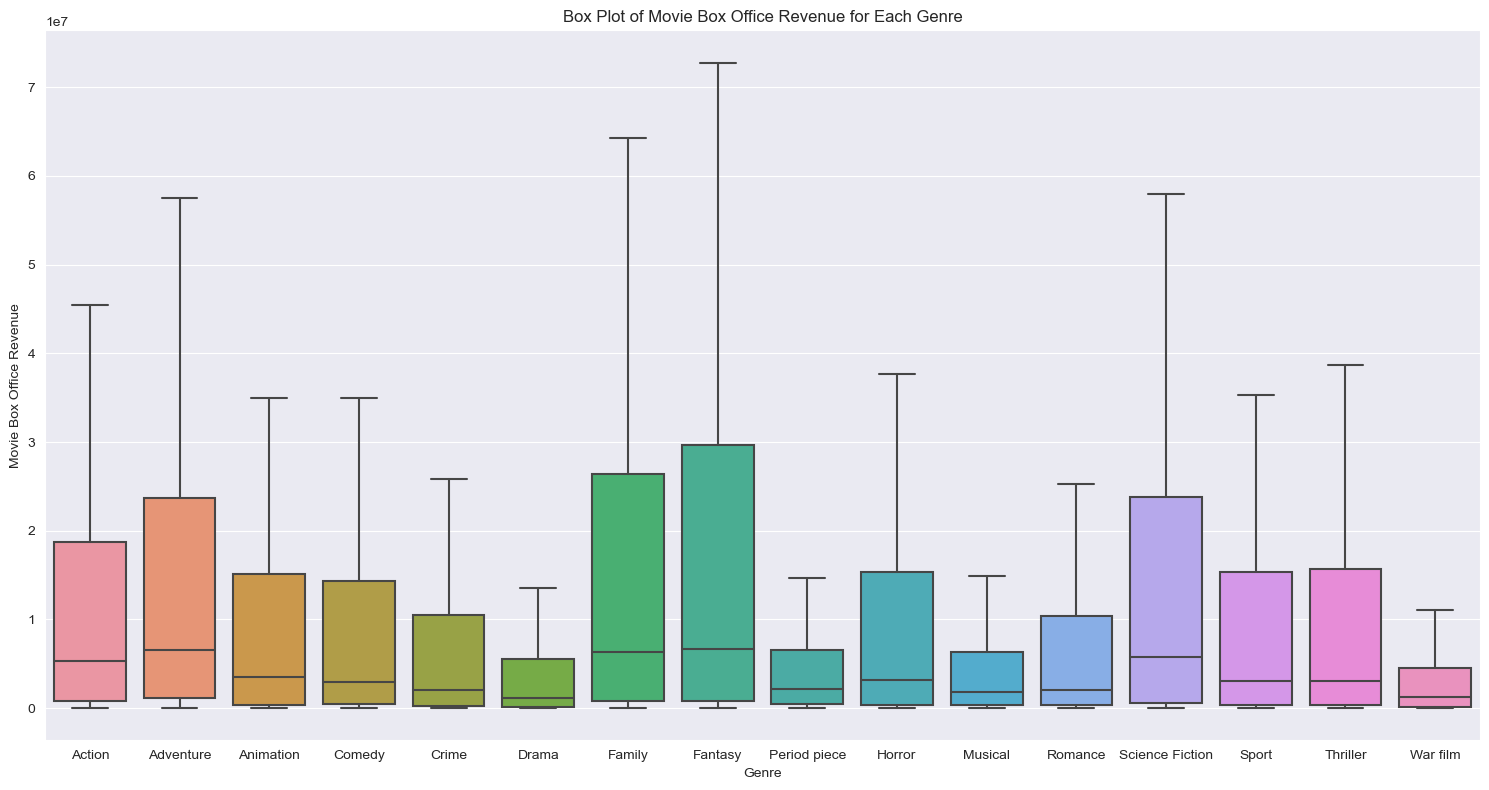

In [71]:
# Create a list to store DataFrames for box plots
boxplot_genre_dfs = []

# Iterate through the genres and corresponding DataFrames
for genre, genre_df in genre_dataframes.items():
    # Use .copy() to create a copy and add a 'Genre' column
    genre_df_copy = genre_df.copy()
    genre_df_copy['Genre'] = genre
    boxplot_genre_dfs.append(genre_df_copy[['revenue', 'Genre']])


# Concatenate the DataFrames along the rows for box plot
boxplot_concat = pd.concat(boxplot_genre_dfs)

# Create a box plot using Seaborn
plt.figure(figsize=(15, 8))
sns.boxplot(x='Genre', y='revenue', data=boxplot_concat, showfliers=False)
plt.title('Box Plot of Movie Box Office Revenue for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Movie Box Office Revenue')
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

## 6) Inclusivity

## 7) Sequels

## 8) Actors' popularity

## 9) Movie directors' popularity

## Sentiment analysis of movies endings (IN MILESTONE 3)